In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [2]:
# Bước 1: Tạo dữ liệu mẫu và lưu vào file Excel

In [3]:
def create_sample_data():
    # Tạo dữ liệu mẫu về giá nhà
    np.random.seed(42)
    n_samples = 200
    
    # Tạo các biến độc lập
    area = np.random.randint(50, 300, n_samples)  # Diện tích (m²)
    rooms = np.random.randint(1, 6, n_samples)    # Số phòng
    age = np.random.randint(0, 50, n_samples)     # Tuổi nhà (năm)
    floor = np.random.randint(1, 20, n_samples)   # Tầng
    distance_to_center = np.random.uniform(0.1, 10, n_samples)  # Khoảng cách đến trung tâm (km)
    
    # Tạo biến phụ thuộc (giá nhà) với một số nhiễu
    price = (
        3000 * area + 
        15000 * rooms - 
        2000 * age + 
        5000 * floor - 
        10000 * distance_to_center + 
        np.random.normal(0, 100000, n_samples)
    )
    
    # Tạo DataFrame
    data = pd.DataFrame({
        'area': area,
        'rooms': rooms,
        'age': age,
        'floor': floor,
        'distance_to_center': distance_to_center,
        'price': price
    })
    
    # Lưu vào file Excel
    data.to_excel('house_price_data.xlsx', index=False)
    print("Đã tạo và lưu file 'house_price_data.xlsx'")
    return data

In [4]:
create_sample_data()

Đã tạo và lưu file 'house_price_data.xlsx'


,area,rooms,age,floor,distance_to_center,price
0,152,5,41,13,7.006655,3.420715e+05
1,229,5,25,19,7.985071,1.024769e+06
2,142,3,34,17,4.647533,5.829498e+05
3,64,5,49,4,8.436705,5.727407e+04
4,156,4,24,12,7.712286,4.656036e+05
...,...,...,...,...,...,...
195,290,1,16,6,5.411165,8.904592e+05
196,101,1,48,1,3.850333,1.688964e+05
197,145,1,19,15,4.624302,3.443762e+05
198,181,3,47,10,6.079183,5.488965e+05


In [5]:
# Bước 2: Đọc dữ liệu từ file Excel

In [6]:
try:
    # Thay đổi đường dẫn nếu file của bạn ở vị trí khác
    df = pd.read_excel('house_price_data.xlsx')
    print("Đã đọc thành công file Excel.")
except FileNotFoundError:
    print("Không tìm thấy file Excel. Tạo dữ liệu mẫu...")
    df = create_sample_data()

Đã đọc thành công file Excel.


In [8]:
# Bước 3: Chuyển đổi bài toán thành bài toán phân loại
# Xác định ngưỡng giá để phân loại nhà có "giá cao" (1) hay "giá thấp" (0)
threshold = df['price'].median()
print(f"\nNgưỡng giá phân loại: {threshold:,.2f}")

# Tạo biến target mới cho bài toán phân loại
df['high_price'] = (df['price'] > threshold).astype(int)
print(f"Phân phối lớp: {df['high_price'].value_counts().to_dict()}")


Ngưỡng giá phân loại: 533,652.52
Phân phối lớp: {0: 100, 1: 100}


In [9]:
# Bước 4: Khám phá dữ liệu
print("\nThông tin về tập dữ liệu:")
print(f"Kích thước dữ liệu: {df.shape}")
print("\nNăm dòng đầu tiên:")
print(df.head())

print("\nThống kê mô tả:")
print(df.describe())

print("\nKiểm tra giá trị null:")
print(df.isnull().sum())


Thông tin về tập dữ liệu:
Kích thước dữ liệu: (200, 7)

Năm dòng đầu tiên:
   area  rooms  age  floor  distance_to_center         price  high_price
0   152      5   41     13            7.006655  3.420715e+05           0
1   229      5   25     19            7.985071  1.024769e+06           1
2   142      3   34     17            4.647533  5.829498e+05           1
3    64      5   49      4            8.436705  5.727407e+04           0
4   156      4   24     12            7.712286  4.656036e+05           0

Thống kê mô tả:
             area       rooms         age       floor  distance_to_center  \
count  200.000000  200.000000  200.000000  200.000000          200.000000   
mean   174.995000    2.855000   25.425000   10.125000            5.169353   
std     75.042601    1.412071   14.098875    5.646129            2.722569   
min     50.000000    1.000000    0.000000    1.000000            0.125691   
25%    106.250000    1.000000   14.000000    5.000000            3.346906   
50%    

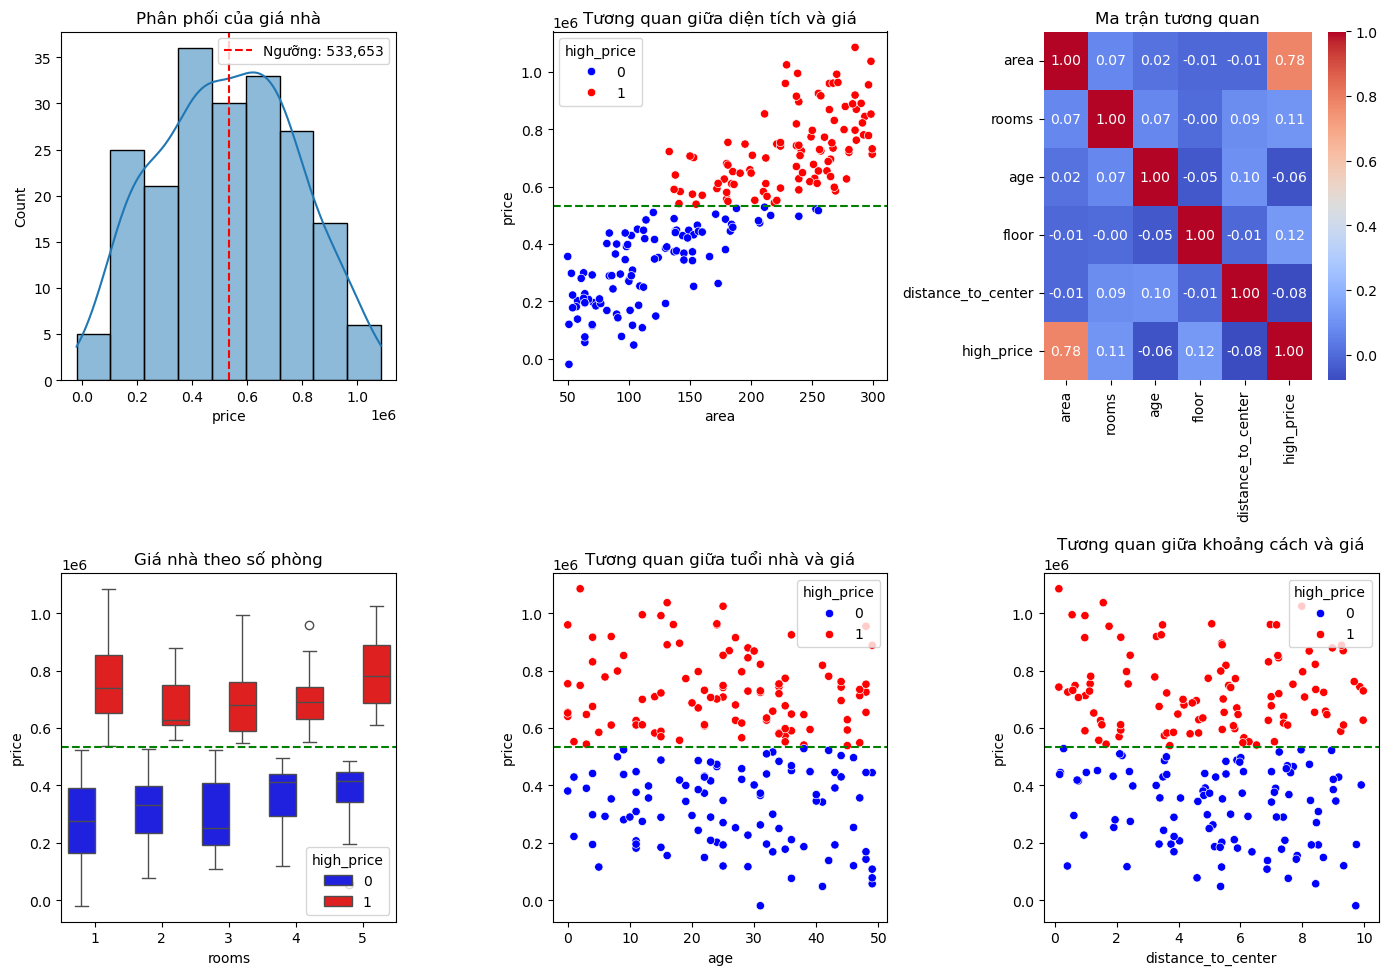

In [10]:
# Bước 5: Trực quan hóa dữ liệu
plt.figure(figsize=(14, 10))

# Histogram của giá nhà với ngưỡng phân loại
plt.subplot(2, 3, 1)
sns.histplot(df['price'], kde=True)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Ngưỡng: {threshold:,.0f}')
plt.title('Phân phối của giá nhà')
plt.legend()

# Tương quan giữa diện tích và giá với màu phân loại
plt.subplot(2, 3, 2)
sns.scatterplot(x='area', y='price', hue='high_price', data=df, palette={0: 'blue', 1: 'red'})
plt.axhline(y=threshold, color='green', linestyle='--')
plt.title('Tương quan giữa diện tích và giá')

# Ma trận tương quan
plt.subplot(2, 3, 3)
corr_matrix = df.drop('price', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')

# Biểu đồ hộp về giá theo số phòng với màu phân loại
plt.subplot(2, 3, 4)
sns.boxplot(x='rooms', y='price', hue='high_price', data=df, palette={0: 'blue', 1: 'red'})
plt.axhline(y=threshold, color='green', linestyle='--')
plt.title('Giá nhà theo số phòng')

# Biểu đồ phân tán giữa tuổi và giá
plt.subplot(2, 3, 5)
sns.scatterplot(x='age', y='price', hue='high_price', data=df, palette={0: 'blue', 1: 'red'})
plt.axhline(y=threshold, color='green', linestyle='--')
plt.title('Tương quan giữa tuổi nhà và giá')

# Biểu đồ phân tán giữa khoảng cách và giá
plt.subplot(2, 3, 6)
sns.scatterplot(x='distance_to_center', y='price', hue='high_price', data=df, palette={0: 'blue', 1: 'red'})
plt.axhline(y=threshold, color='green', linestyle='--')
plt.title('Tương quan giữa khoảng cách và giá')

plt.tight_layout()
plt.show()

In [ ]:
# Bước 6: Chuẩn bị dữ liệu cho mô hình

In [12]:
X = df.drop(['price', "high_price"], axis=1)
y = df["high_price"]

In [13]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")


Kích thước tập huấn luyện: (160, 5)
Kích thước tập kiểm tra: (40, 5)


In [14]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Bước 7: Xây dựng và huấn luyện mô hình Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Bước 8: Kiểm tra hệ số hồi quy
coef_df = pd.DataFrame({
    'Đặc trưng': X.columns,
    'Hệ số': model.coef_[0]
})
print("\nHệ số hồi quy logistic (đã chuẩn hóa):")
print(coef_df.sort_values(by='Hệ số', ascending=False))
print(f"Hệ số chặn (Intercept): {model.intercept_[0]:.4f}")


Hệ số hồi quy logistic (đã chuẩn hóa):
            Đặc trưng     Hệ số
0                area  2.744885
1               rooms  0.382807
3               floor  0.335029
4  distance_to_center -0.400958
2                 age -0.401649
Hệ số chặn (Intercept): -0.0838


In [20]:
# Bước 9: Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nĐánh giá mô hình:")
print(f"Độ chính xác (Accuracy): {accuracy:.4f}")
print("\nMa trận nhầm lẫn:")
print(conf_matrix)
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))


Đánh giá mô hình:
Độ chính xác (Accuracy): 0.9500

Ma trận nhầm lẫn:
[[20  0]
 [ 2 18]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



Text(0.5, 1.0, 'Ma trận nhầm lẫn')

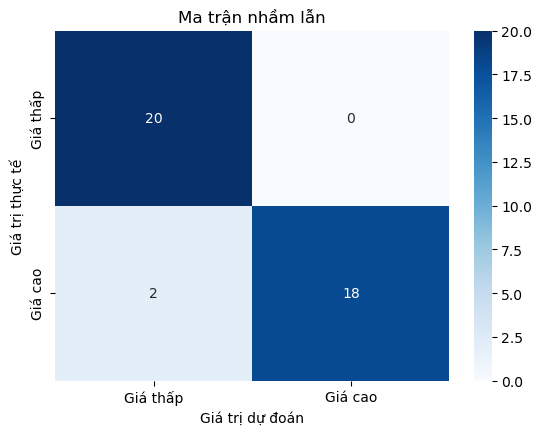

In [21]:
# Bước 10: Trực quan hóa kết quả
plt.figure(figsize=(14, 10))

# Ma trận nhầm lẫn
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Giá thấp', 'Giá cao'], 
            yticklabels=['Giá thấp', 'Giá cao'])
plt.ylabel('Giá trị thực tế')
plt.xlabel('Giá trị dự đoán')
plt.title('Ma trận nhầm lẫn')

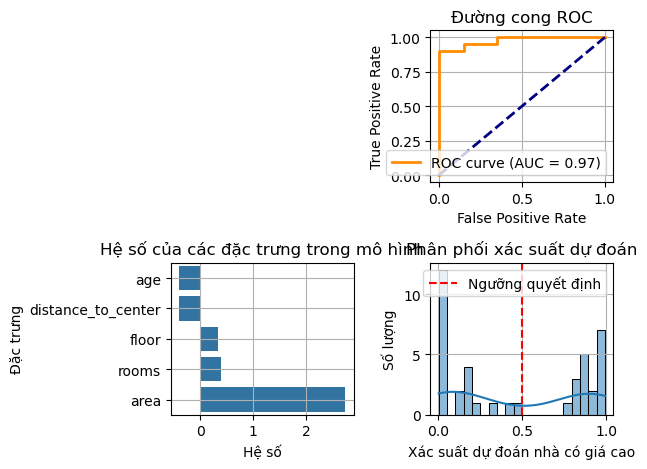

In [22]:
# Đường cong ROC
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC')
plt.legend(loc='lower right')
plt.grid(True)

# Phân tích hệ số
plt.subplot(2, 2, 3)
coef_df_sorted = coef_df.sort_values(by='Hệ số')
sns.barplot(x='Hệ số', y='Đặc trưng', data=coef_df_sorted)
plt.title('Hệ số của các đặc trưng trong mô hình')
plt.grid(True)

# Phân phối xác suất dự đoán
plt.subplot(2, 2, 4)
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.axvline(x=0.5, color='red', linestyle='--', label='Ngưỡng quyết định')
plt.xlabel('Xác suất dự đoán nhà có giá cao')
plt.ylabel('Số lượng')
plt.title('Phân phối xác suất dự đoán')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# Bước 11: Lựa chọn đặc trưng
# Sử dụng RFE (Recursive Feature Elimination) để chọn đặc trưng
rfe = RFE(estimator=LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=3)
rfe.fit(X_train_scaled, y_train)

print("\nKết quả lựa chọn đặc trưng:")
result = pd.DataFrame({
    'Đặc trưng': X.columns,
    'Chọn': rfe.support_,
    'Thứ hạng': rfe.ranking_
})
print(result.sort_values('Thứ hạng'))


Kết quả lựa chọn đặc trưng:
            Đặc trưng   Chọn  Thứ hạng
0                area   True         1
2                 age   True         1
4  distance_to_center   True         1
1               rooms  False         2
3               floor  False         3


In [25]:
# Bước 12: Xây dựng mô hình mới chỉ với các đặc trưng được chọn
selected_features = X.columns[rfe.support_].tolist()
print(f"\nCác đặc trưng được chọn: {selected_features}")

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Chuẩn hóa lại
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

# Huấn luyện mô hình mới
# Bước 13: So sánh với mô hình ban đầu
print("\nSo sánh các mô hình:")
comparison = pd.DataFrame({
    'Mô hình': ['Tất cả đặc trưng', 'Đặc trưng đã chọn'],
    'Độ chính xác': [accuracy, accuracy_selected],
})
print(comparison) = LogisticRegression(max_iter=1000, random_state=42)
model_selected.fit(X_train_selected_scaled, y_train)

# Dự đoán và đánh giá
y_pred_selected = model_selected.predict(X_test_selected_scaled)
accuracy_selected = accuracy_score(y_test, y_pred_selected)

print("\nĐánh giá mô hình với các đặc trưng đã chọn:")
print(f"Độ chính xác (Accuracy): {accuracy_selected:.4f}")
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_selected))


Các đặc trưng được chọn: ['area', 'age', 'distance_to_center']

Đánh giá mô hình với các đặc trưng đã chọn:
Độ chính xác (Accuracy): 0.9000

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.90      0.90      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [26]:
# Bước 13: So sánh với mô hình ban đầu
print("\nSo sánh các mô hình:")
comparison = pd.DataFrame({
    'Mô hình': ['Tất cả đặc trưng', 'Đặc trưng đã chọn'],
    'Độ chính xác': [accuracy, accuracy_selected],
})
print(comparison)


So sánh các mô hình:
             Mô hình  Độ chính xác
0   Tất cả đặc trưng          0.95
1  Đặc trưng đã chọn          0.90


In [27]:
# Bước 14: Thử nghiệm mô hình với dữ liệu mới
print("\nThử nghiệm mô hình với dữ liệu mới:")
# Tạo một căn nhà mẫu để dự đoán
new_house = pd.DataFrame({
    'area': [120],
    'rooms': [3],
    'age': [5],
    'floor': [10],
    'distance_to_center': [2.5]
})
print("Thông tin căn nhà mẫu:")
print(new_house)

# Chuẩn hóa dữ liệu mới
new_house_scaled = scaler.transform(new_house)
predicted_proba = model.predict_proba(new_house_scaled)[0]
predicted_class = model.predict(new_house_scaled)[0]

# Đưa ra dự đoán
print(f"\nXác suất nhà có giá cao: {predicted_proba[1]:.4f} ({predicted_proba[1]*100:.2f}%)")
print(f"Xác suất nhà có giá thấp: {predicted_proba[0]:.4f} ({predicted_proba[0]*100:.2f}%)")
if predicted_class == 1:
    print("Dự đoán: Nhà có giá CAO (> {threshold:,.2f})")
else:
    print(f"Dự đoán: Nhà có giá THẤP (≤ {threshold:,.2f})")


Thử nghiệm mô hình với dữ liệu mới:
Thông tin căn nhà mẫu:
   area  rooms  age  floor  distance_to_center
0   120      3    5     10                 2.5

Xác suất nhà có giá cao: 0.2418 (24.18%)
Xác suất nhà có giá thấp: 0.7582 (75.82%)
Dự đoán: Nhà có giá THẤP (≤ 533,652.52)


In [30]:
# Bước 15: Lưu mô hình để sử dụng sau này
import joblib

# Lưu mô hình, bộ chuẩn hóa và ngưỡng phân loại
joblib.dump(model, 'house_price_logistic_model.pkl')
joblib.dump(scaler, 'house_price_logistic_scaler.pkl')
joblib.dump(threshold, 'house_price_threshold.pkl')

print("\nĐã lưu mô hình vào 'house_price_logistic_model.pkl', bộ chuẩn hóa vào 'house_price_logistic_scaler.pkl',")
print("và ngưỡng phân loại vào 'house_price_threshold.pkl'")
print("Để sử dụng mô hình sau này:")

model = joblib.load('house_price_logistic_model.pkl')
scaler = joblib.load('house_price_logistic_scaler.pkl')
threshold = joblib.load('house_price_threshold.pkl')


Đã lưu mô hình vào 'house_price_logistic_model.pkl', bộ chuẩn hóa vào 'house_price_logistic_scaler.pkl',
và ngưỡng phân loại vào 'house_price_threshold.pkl'
Để sử dụng mô hình sau này:


In [31]:
# Chuẩn bị dữ liệu mới
new_data = pd.DataFrame({
    'area': [120],
    'rooms': [3],
    'age': [5],
    'floor': [10],
    'distance_to_center': [2.5]
})

# Chuẩn hóa và dự đoán
new_data_scaled = scaler.transform(new_data)
predicted_proba = model.predict_proba(new_data_scaled)[0]
predicted_class = model.predict(new_data_scaled)[0]

# Đưa ra dự đoán
print(f"Xác suất nhà có giá cao: {predicted_proba[1]:.4f} ({predicted_proba[1]*100:.2f}%)")
if predicted_class == 1:
    print(f"Dự đoán: Nhà có giá CAO (> {threshold:,.2f})")
else:
    print(f"Dự đoán: Nhà có giá THẤP (≤ {threshold:,.2f})")

Xác suất nhà có giá cao: 0.2418 (24.18%)
Dự đoán: Nhà có giá THẤP (≤ 533,652.52)
